https://www.angioi.com/dog-breed-classification/

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

dataset, info = tfds.load(name="stanford_dogs", with_info=True)

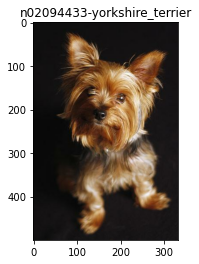

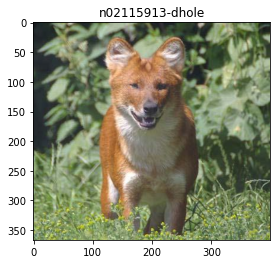

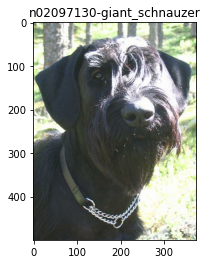

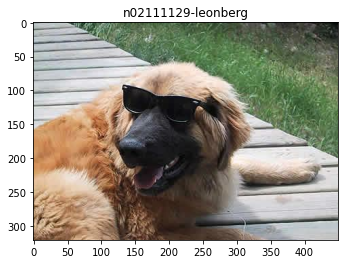

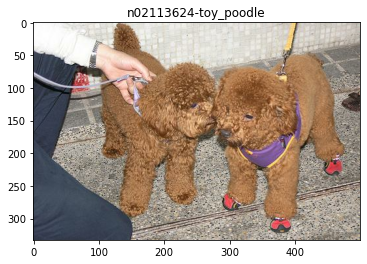

In [2]:
# function to convert label indices to breed names 
get_name = info.features['label'].int2str

for doggo in dataset['train'].take(5):
    plt.figure()
    plt.imshow(doggo['image'])
    plt.title(get_name(doggo['label']))

In [3]:
IMG_LEN = 224
IMG_SHAPE = (IMG_LEN,IMG_LEN,3)
N_BREEDS = 120

training_data = dataset['train']
test_data = dataset['test']

def preprocess(ds_row):
  
    # Image conversion int->float + resizing
    image = tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32)
    image = tf.image.resize(image, (IMG_LEN, IMG_LEN), method='nearest')
  
    # Onehot encoding labels
    label = tf.one_hot(ds_row['label'],N_BREEDS)

    return image, label

def prepare(dataset, batch_size=None):
    ds = dataset.map(preprocess, num_parallel_calls=4)
    ds = ds.shuffle(buffer_size=1000)
    if batch_size:
        ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [4]:
import tensorflow as tf

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [5]:
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(N_BREEDS, activation='softmax')
])

In [6]:
# Didn't do any hyperparameter optimization
model.compile(optimizer=tf.keras.optimizers.Adamax(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])
			  
train_batches = prepare(training_data, batch_size=32)
test_batches = prepare(test_data, batch_size=32)

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=test_batches)

Epoch 1/30
375/375 [==============================] - 55s 130ms/step - loss: 4.8254 - accuracy: 0.0251 - top_k_categorical_accuracy: 0.0969 - val_loss: 4.2898 - val_accuracy: 0.0767 - val_top_k_categorical_accuracy: 0.2428
Epoch 2/30
375/375 [==============================] - 48s 124ms/step - loss: 4.1379 - accuracy: 0.1120 - top_k_categorical_accuracy: 0.3057 - val_loss: 3.8463 - val_accuracy: 0.1653 - val_top_k_categorical_accuracy: 0.4465
Epoch 3/30
375/375 [==============================] - 48s 124ms/step - loss: 3.6978 - accuracy: 0.2095 - top_k_categorical_accuracy: 0.5214 - val_loss: 3.4644 - val_accuracy: 0.2682 - val_top_k_categorical_accuracy: 0.6197
Epoch 4/30
375/375 [==============================] - 48s 124ms/step - loss: 3.3168 - accuracy: 0.3102 - top_k_categorical_accuracy: 0.6828 - val_loss: 3.1335 - val_accuracy: 0.3633 - val_top_k_categorical_accuracy: 0.7322
Epoch 5/30
375/375 [==============================] - 50s 131ms/step - loss: 2.9902 - accuracy: 0.4011 - top

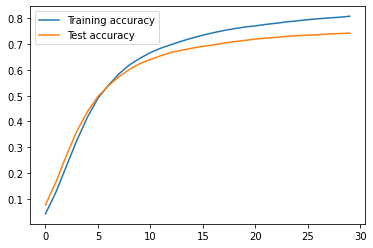

In [7]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.legend();